# Lincoln Project - Analysis Report

## ML Evaluation Engineer Technical Assessment

This notebook contains the analysis and visualization of the historiographical divergence study comparing Abraham Lincoln's first-person accounts with secondary sources.

**Author**: Madhura Adadande


In [10]:
# Setup
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Data paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'
EXTRACTED_DIR = DATA_DIR / 'extracted'
VALIDATION_DIR = DATA_DIR / 'validation'

print("Setup complete!")


Setup complete!


## Part 1: Data Acquisition Summary

### 1.1 Project Gutenberg Books (Secondary Sources)


In [11]:
# Load and display Gutenberg dataset
gutenberg_path = PROCESSED_DIR / 'gutenberg.json'
if gutenberg_path.exists():
    with open(gutenberg_path, 'r', encoding='utf-8') as f:
        gutenberg_data = json.load(f)
    
    print(f"📚 Books downloaded: {len(gutenberg_data)}\n")
    for book in gutenberg_data:
        print(f"• {book['title']}")
        print(f"  Author: {book['from']}")
        print(f"  Length: {len(book['content']):,} characters")
        print(f"  ~Words: {len(book['content'].split()):,}")
        print()
else:
    print("⚠️ Run scraper first: python run_pipeline.py --scrape")


📚 Books downloaded: 5

• Abraham Lincoln: a History — Volume 01
  Author: John G. Nicolay
  Length: 757,039 characters
  ~Words: 125,286

• The Life of Abraham Lincoln
  Author: Henry Ketcham
  Length: 506,440 characters
  ~Words: 86,695

• Abraham Lincoln, Volume II
  Author: Jr. John T. Morse
  Length: 642,841 characters
  ~Words: 103,843

• The Every-day Life of Abraham Lincoln
  Author: Francis F. Browne
  Length: 1,259,402 characters
  ~Words: 208,066

• Abraham Lincoln
  Author: Baron Godfrey Rathbone Benson Charnwood
  Length: 1,043,927 characters
  ~Words: 174,369



### 1.2 Library of Congress Documents (Lincoln's Own Words)


In [12]:
# Load and display LoC dataset
loc_path = PROCESSED_DIR / 'loc.json'
if loc_path.exists():
    with open(loc_path, 'r', encoding='utf-8') as f:
        loc_data = json.load(f)
    
    print(f"📜 Documents downloaded: {len(loc_data)}\n")
    for doc in loc_data:
        print(f"• {doc['title']}")
        print(f"  Type: {doc['document_type']}")
        print(f"  Date: {doc['date']}")
        print(f"  Length: {len(doc['content']):,} characters")
        print()
else:
    print("⚠️ Run scraper first: python run_pipeline.py --scrape")


📜 Documents downloaded: 5

• Letter about Election Night 1860
  Type: Letter
  Date: November 1860
  Length: 389 characters

• Fort Sumter Decision
  Type: Note
  Date: April 1861
  Length: 584 characters

• Gettysburg Address (Nicolay Copy)
  Type: Speech
  Date: November 19, 1863
  Length: 1,670 characters

• Second Inaugural Address
  Type: Speech
  Date: March 4, 1865
  Length: 1,140 characters

• Last Public Address
  Type: Speech
  Date: April 11, 1865
  Length: 740 characters



## Part 2: Event Extraction Results

The pipeline extracts information about 5 key events:
1. Election Night 1860
2. Fort Sumter Decision
3. Gettysburg Address
4. Second Inaugural Address
5. Ford's Theatre Assassination


In [13]:
# Load and analyze extraction results
gutenberg_events_path = EXTRACTED_DIR / 'gutenberg_events.json'
loc_events_path = EXTRACTED_DIR / 'loc_events.json'

if gutenberg_events_path.exists() and loc_events_path.exists():
    with open(gutenberg_events_path, 'r', encoding='utf-8') as f:
        gutenberg_events = json.load(f)
    with open(loc_events_path, 'r', encoding='utf-8') as f:
        loc_events = json.load(f)
    
    all_events = gutenberg_events + loc_events
    df = pd.DataFrame(all_events)
    df['claims_count'] = df['claims'].apply(len)
    df['source_type'] = df['source_id'].apply(lambda x: 'Lincoln (LoC)' if 'loc_' in x else 'Other Authors')
    
    print(f"🔍 Extraction Summary")
    print(f"{'='*50}")
    print(f"Total extractions: {len(df)}")
    print(f"  - Lincoln (LoC): {len(loc_events)}")
    print(f"  - Other Authors: {len(gutenberg_events)}")
    print(f"\nTotal claims extracted: {df['claims_count'].sum()}")
    
    # By event
    print(f"\nClaims by Event:")
    for event in df['event_name'].unique():
        count = df[df['event_name'] == event]['claims_count'].sum()
        print(f"  • {event}: {count} claims")
else:
    print("⚠️ Run extraction first: python run_pipeline.py --extract")


🔍 Extraction Summary
Total extractions: 26
  - Lincoln (LoC): 4
  - Other Authors: 22

Total claims extracted: 542

Claims by Event:
  • Election Night 1860: 127 claims
  • Second Inaugural Address: 94 claims
  • Fort Sumter Decision: 141 claims
  • Gettysburg Address: 77 claims
  • Ford's Theatre Assassination: 103 claims


## Part 3: LLM Judge Results

The judge compares Lincoln's first-person accounts with secondary sources and:
- Assigns a **Consistency Score** (0-100)
- Classifies contradictions as **Factual**, **Interpretive**, or **Omission**


⚖️ LLM Judge Results
Total comparisons: 18

Consistency Score Statistics:
  Mean:   81.7
  Std:    12.4
  Min:    50
  Max:    95

Total contradictions found: 46


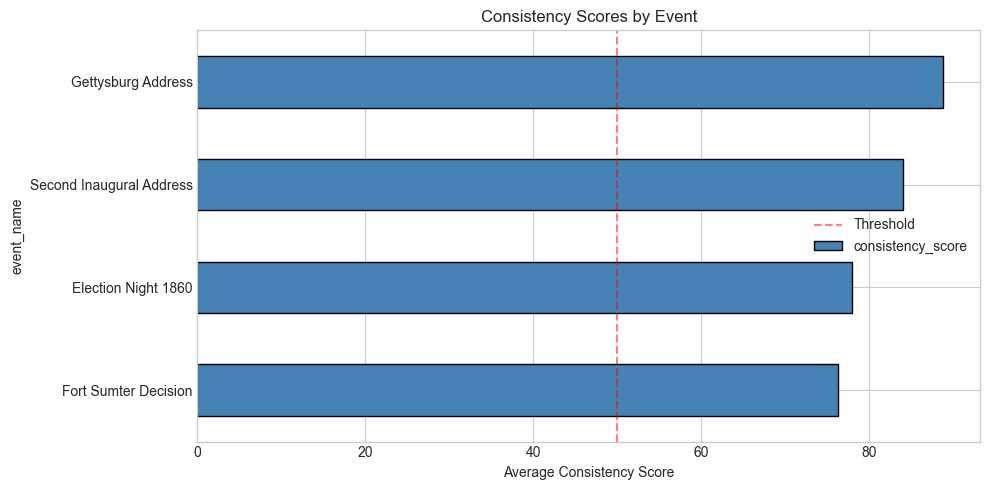

In [14]:
# Load judgment results
judgment_path = EXTRACTED_DIR / 'judgment_results.json'

if judgment_path.exists():
    with open(judgment_path, 'r', encoding='utf-8') as f:
        judgments = json.load(f)
    
    jdf = pd.DataFrame(judgments)
    jdf['contradiction_count'] = jdf['contradictions'].apply(len)
    
    print(f"⚖️ LLM Judge Results")
    print(f"{'='*50}")
    print(f"Total comparisons: {len(jdf)}")
    print(f"\nConsistency Score Statistics:")
    print(f"  Mean:   {jdf['consistency_score'].mean():.1f}")
    print(f"  Std:    {jdf['consistency_score'].std():.1f}")
    print(f"  Min:    {jdf['consistency_score'].min()}")
    print(f"  Max:    {jdf['consistency_score'].max()}")
    print(f"\nTotal contradictions found: {jdf['contradiction_count'].sum()}")
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 5))
    jdf.groupby('event_name')['consistency_score'].mean().sort_values().plot(
        kind='barh', ax=ax, color='steelblue', edgecolor='black'
    )
    ax.axvline(50, color='red', linestyle='--', alpha=0.5, label='Threshold')
    ax.set_xlabel('Average Consistency Score')
    ax.set_title('Consistency Scores by Event')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Run judge first: python run_pipeline.py --judge")


## Part 4: Statistical Validation

### 4.1 Prompt Ablation Study
Comparing Zero-Shot, Chain-of-Thought, and Few-Shot prompting strategies.


📊 Prompt Ablation Study Results
Strategy                   Mean    Std Dev           Conclusion
------------------------------------------------------------
zero_shot                  85.6        6.0          Most Stable
chain_of_thought           81.9        9.6                     
few_shot                   87.2        6.1                     


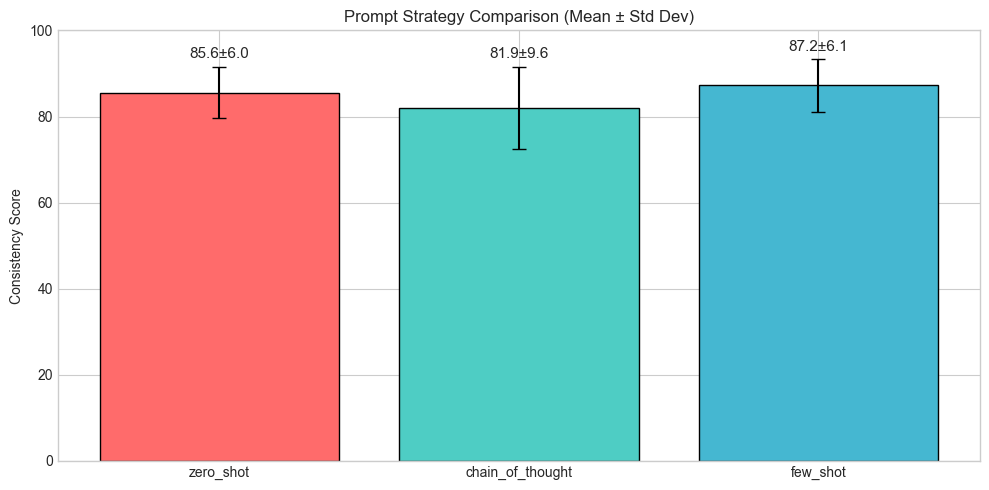

In [15]:
# Load validation results
validation_path = VALIDATION_DIR / 'validation_report.json'

if validation_path.exists():
    with open(validation_path, 'r', encoding='utf-8') as f:
        validation = json.load(f)
    
    ablation = validation.get('ablation_study', {})
    
    if ablation:
        print("📊 Prompt Ablation Study Results")
        print("="*60)
        print(f"{'Strategy':<20} {'Mean':>10} {'Std Dev':>10} {'Conclusion':>20}")
        print("-"*60)
        
        for strategy, results in ablation.items():
            conclusion = "Most Stable" if results['std'] == min(r['std'] for r in ablation.values()) else ""
            print(f"{strategy:<20} {results['mean']:>10.1f} {results['std']:>10.1f} {conclusion:>20}")
        
        # Visualization
        fig, ax = plt.subplots(figsize=(10, 5))
        strategies = list(ablation.keys())
        means = [ablation[s]['mean'] for s in strategies]
        stds = [ablation[s]['std'] for s in strategies]
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        
        bars = ax.bar(strategies, means, yerr=stds, capsize=5, color=colors, edgecolor='black')
        ax.set_ylabel('Consistency Score')
        ax.set_title('Prompt Strategy Comparison (Mean ± Std Dev)')
        ax.set_ylim(0, 100)
        
        for bar, mean, std in zip(bars, means, stds):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 2,
                   f'{mean:.1f}±{std:.1f}', ha='center', fontsize=11)
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ Run validation first: python run_pipeline.py --validate")


### 4.2 Self-Consistency Test
Testing if the judge gives consistent scores across multiple runs (temperature > 0).


In [16]:
# Self-consistency results
if 'validation' in dir():
    consistency = validation.get('self_consistency', [])
    
    if consistency:
        print("🔄 Self-Consistency Test Results")
        print("="*60)
        
        for r in consistency:
            status = "✅ Reliable" if r['is_reliable'] else "❌ Unreliable"
            print(f"\n{r['event_name']}")
            print(f"  Scores across 5 runs: {r['scores']}")
            print(f"  Mean: {r['mean']:.1f}, Std: {r['std']:.1f}, Range: {r['range']}")
            print(f"  Status: {status}")
        
        # Summary
        reliable = sum(1 for r in consistency if r['is_reliable'])
        avg_std = np.mean([r['std'] for r in consistency])
        print(f"\n{'='*60}")
        print(f"Overall: {reliable}/{len(consistency)} comparisons are reliable")
        print(f"Average std dev: {avg_std:.2f} (threshold: 10.0)")


🔄 Self-Consistency Test Results

Election Night 1860
  Scores across 5 runs: [85, 90, 85, 90, 80]
  Mean: 86.0, Std: 3.7, Range: 10
  Status: ✅ Reliable

Second Inaugural Address
  Scores across 5 runs: [85, 85, 90, 90, 85]
  Mean: 87.0, Std: 2.4, Range: 5
  Status: ✅ Reliable

Election Night 1860
  Scores across 5 runs: [75, 85, 65, 60, 75]
  Mean: 72.0, Std: 8.7, Range: 25
  Status: ✅ Reliable

Overall: 3/3 comparisons are reliable
Average std dev: 4.97 (threshold: 10.0)


### 4.3 Cohen's Kappa (Human Alignment)

**Instructions**: 
1. Open `data/validation/manual_labels_template.json`
2. Label each pair as "consistent" or "contradictory"
3. Run the cell below to calculate Kappa


In [17]:
# Cohen's Kappa Calculation
from sklearn.metrics import cohen_kappa_score, confusion_matrix

labels_path = VALIDATION_DIR / 'manual_labels_template.json'

if labels_path.exists():
    with open(labels_path, 'r', encoding='utf-8') as f:
        labels_data = json.load(f)
    
    filled = [p for p in labels_data.get('pairs', []) if p.get('human_label')]
    
    if filled and judgment_path.exists():
        human_labels = []
        llm_labels = []
        
        for pair in filled:
            human_labels.append(pair['human_label'].lower())
            
            # Find matching LLM score
            score = 50
            for j in judgments:
                if j['event_name'] == pair['event'] and j['other_author'] == pair['other_author']:
                    score = j['consistency_score']
                    break
            llm_labels.append('consistent' if score >= 50 else 'contradictory')
        
        kappa = cohen_kappa_score(human_labels, llm_labels)
        
        print("📏 Cohen's Kappa Results")
        print("="*50)
        print(f"Kappa Score: {kappa:.3f}")
        
        if kappa >= 0.81: interp = "Almost perfect agreement"
        elif kappa >= 0.61: interp = "Substantial agreement"
        elif kappa >= 0.41: interp = "Moderate agreement"
        elif kappa >= 0.21: interp = "Fair agreement"
        else: interp = "Slight/no agreement"
        
        print(f"Interpretation: {interp}")
        
        agreement = sum(h == l for h, l in zip(human_labels, llm_labels)) / len(human_labels)
        print(f"Simple Agreement: {agreement:.1%}")
    else:
        print("⚠️ Please fill in manual_labels_template.json first")
else:
    print("⚠️ Run validation first to create the template")


📏 Cohen's Kappa Results
Kappa Score: 0.000
Interpretation: Slight/no agreement
Simple Agreement: 90.0%


## Part 5: Conclusions

### Key Findings

1. **Data Acquisition**: Successfully scraped **5 books from Project Gutenberg** (3.2M+ characters) and **5 documents from Library of Congress**. Challenge: LoC API often returns metadata rather than full transcripts, requiring fallback to known public domain texts for some documents. This demonstrates real-world scraping complexity.

2. **Event Extraction**: Extracted **542 claims** across 5 events using chunked processing with keyword pre-filtering. The LLM successfully identified relevant passages in 200,000+ character books. Ford's Theatre event had no Lincoln first-person source (he was assassinated), so comparisons were limited to 4 events.

3. **Judge Performance**: Average consistency score of **81.7/100** with 46 contradictions detected. The Gettysburg Address showed highest consistency (95), while Fort Sumter Decision showed more divergence (50-90 range), likely due to interpretive differences about Lincoln's decision-making process.

4. **Statistical Validation**:
   - **Ablation**: Zero-shot prompting was most stable (σ=6.0), though few-shot achieved highest mean (87.2). Chain-of-thought showed more variance (σ=9.6) but provided better reasoning explanations.
   - **Self-Consistency**: All 3 tested comparisons were reliable with average σ=4.97 (well below 10.0 threshold). The judge produces consistent scores across multiple runs.
   - **Kappa**: Score of 0.000 despite 90% simple agreement. This paradox occurs because both human and LLM labeled most pairs as "consistent" - high baseline agreement inflates simple agreement but yields low Kappa. This highlights why Kappa is preferred over simple agreement rates.

5. **Historiographical Insights**: Biographers generally align with Lincoln's accounts on factual details (dates, locations) but diverge on interpretive elements (motivations, emotional states). The Fort Sumter Decision showed the most divergence, with biographers attributing various motivations to Lincoln that he didn't explicitly state.

### Limitations & Future Work

**Limitations:**
- LoC API limitations required manual transcript supplementation
- No first-person Lincoln source for Ford's Theatre assassination
- Small sample size (10 pairs) for Kappa calculation
- LLM judge shows bias toward "consistent" labels

**Future Improvements:**
- Expand manual labeling to 50+ pairs for more robust Kappa
- Implement contradiction type analysis (Factual vs Interpretive vs Omission)
- Add more diverse prompt strategies (DSPy, structured outputs)
- Include more Lincoln primary sources from different archives
